
✅ 成功加载数据：Data_Set_(A+B).xlsx
📊 数据维度：176 样本 × 16 特征
🎯 类别分布：
Type
2    36
5    36
4    36
1    35
3    33
Name: count, dtype: int64

🎓 开始模型训练...


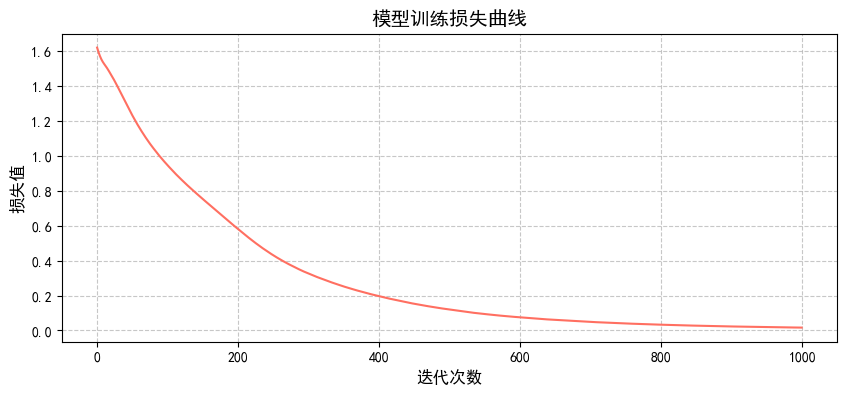


✅ 成功加载数据：Data_Set_C.xlsx
📊 数据维度：58 样本 × 16 特征
🎯 类别分布：
Type
2    12
5    12
4    12
1    11
3    11
Name: count, dtype: int64

🔍 正在执行独立验证...

📈 评估结果：
准确率：0.879
F1得分：0.878

📝 分类报告：
              precision    recall  f1-score   support

           1       0.90      0.82      0.86        11
           2       1.00      0.83      0.91        12
           3       0.82      0.82      0.82        11
           4       0.92      1.00      0.96        12
           5       0.79      0.92      0.85        12

    accuracy                           0.88        58
   macro avg       0.89      0.88      0.88        58
weighted avg       0.89      0.88      0.88        58



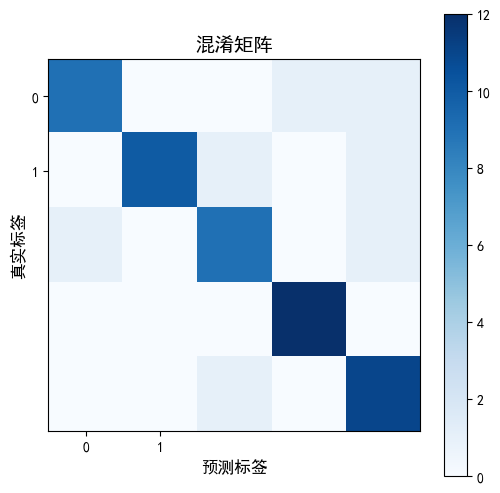


💾 模型已保存至：地面分类模型.pkl

🔧 正在进行平衡数据实验...

🔄 正在使用 SMOTE 平衡数据...

🎓 开始模型训练...


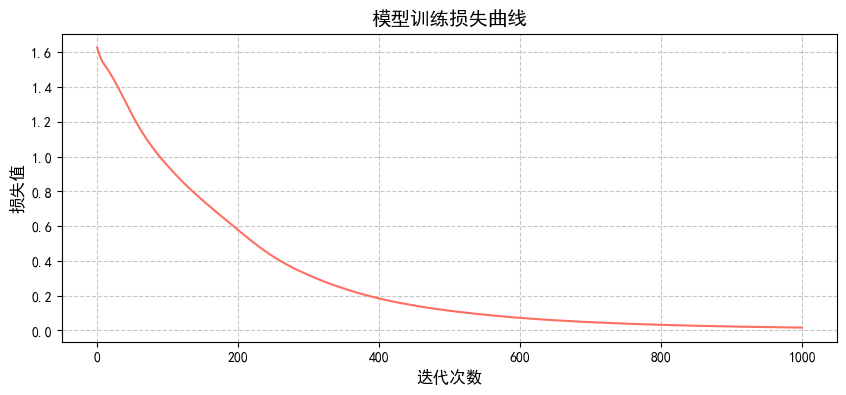


📈 评估结果：
准确率：0.845
F1得分：0.840

📝 分类报告：
              precision    recall  f1-score   support

           1       0.89      0.73      0.80        11
           2       0.83      0.83      0.83        12
           3       0.80      0.73      0.76        11
           4       0.92      1.00      0.96        12
           5       0.79      0.92      0.85        12

    accuracy                           0.84        58
   macro avg       0.85      0.84      0.84        58
weighted avg       0.85      0.84      0.84        58



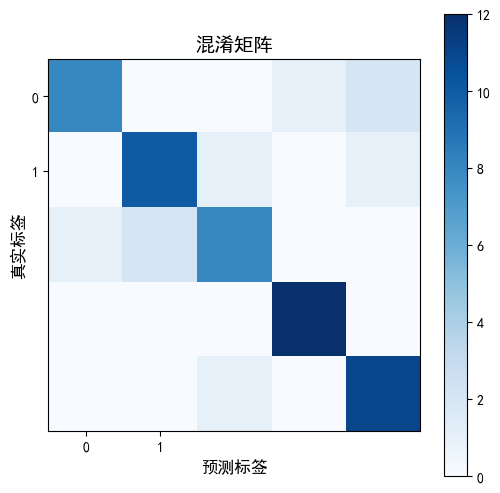

In [4]:
# -*- coding: utf-8 -*-
"""
地面分类系统 - 可直接运行版本
使用说明：
1. 在下方「用户配置区」设置文件路径
2. 确保已安装所需库：pandas, scikit-learn, imbalanced-learn, matplotlib
3. 直接运行整个脚本
"""

# %% ==================== 用户配置区 ====================
# 在此设置您的文件路径（保持文件扩展名正确）
TRAIN_PATH = 'C:/Users/HUAWEI/Desktop/lp2/Data_Set_(A+B).xlsx'  # 示例：'D:/data/Data_Set_(A+B).xlsx'
TEST_PATH = 'C:/Users/HUAWEI/Desktop/lp2/Data_Set_C.xlsx'       # 示例：'D:/data/Data_Set_C.xlsx'
MODEL_SAVE_PATH = '地面分类模型.pkl'              # 模型保存路径

# %% ==================== 初始化环境 ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
import joblib
import warnings
warnings.filterwarnings('ignore')

# 中文显示设置
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# %% ==================== 数据处理器 ====================
class DataProcessor:
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.is_fitted = False

    def load_data(self, path):
        """加载并验证数据"""
        try:
            df = pd.read_excel(path)
            X = df.drop('Type', axis=1)
            y = df['Type']
            print(f"\n✅ 成功加载数据：{path.split('/')[-1]}")
            print(f"📊 数据维度：{df.shape[0]} 样本 × {df.shape[1]} 特征")
            print(f"🎯 类别分布：\n{y.value_counts()}")
            return X, y
        except Exception as e:
            print(f"\n❌ 数据加载失败：{str(e)}")
            print(f"⚠️ 请检查：1. 文件路径是否正确 2. 文件是否被占用 3. 文件格式是否正确")
            exit()

    def normalize(self, X, is_train=True):
        """数据归一化处理"""
        if is_train:
            self.scaler.fit(X)
            self.is_fitted = True
            return self.scaler.transform(X)
        else:
            if not self.is_fitted:
                raise ValueError("请先使用训练数据拟合归一化器")
            return self.scaler.transform(X)

    def balance_data(self, X, y, method='SMOTE'):
        """处理数据不平衡"""
        print(f"\n🔄 正在使用 {method} 平衡数据...")
        sampler = SMOTE(random_state=42) if method == 'SMOTE' else ADASYN(random_state=42)
        return sampler.fit_resample(X, y)

# %% ==================== 分类模型 ====================
class SurfaceClassifier:
    def __init__(self):
        self.model = None
        self.train_loss = []
        self.best_params = {
            'hidden_layer_sizes': (100, 50),
            'activation': 'relu',
            'solver': 'adam',
            'max_iter': 1000,
            'random_state': 42
        }

    def train(self, X_train, y_train):
        """训练模型"""
        print("\n🎓 开始模型训练...")
        self.model = MLPClassifier(**self.best_params)
        
        # 分批次记录训练过程
        self.model.partial_fit(X_train, y_train, classes=np.unique(y_train))
        for _ in range(self.best_params['max_iter']):
            self.model.partial_fit(X_train, y_train)
            self.train_loss.append(self.model.loss_)
        
        # 绘制学习曲线
        plt.figure(figsize=(10, 4))
        plt.plot(self.train_loss, color='#FF6F61')
        plt.title('模型训练损失曲线', fontsize=14)
        plt.xlabel('迭代次数', fontsize=12)
        plt.ylabel('损失值', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def evaluate(self, X_test, y_test):
        """模型评估"""
        if self.model is None:
            raise ValueError("模型尚未训练")
            
        y_pred = self.model.predict(X_test)
        
        # 打印评估指标
        print("\n📈 评估结果：")
        print(f"准确率：{accuracy_score(y_test, y_pred):.3f}")
        print(f"F1得分：{f1_score(y_test, y_pred, average='macro'):.3f}")
        print("\n📝 分类报告：")
        print(classification_report(y_test, y_pred))
        
        # 绘制混淆矩阵
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 6))
        plt.imshow(cm, cmap='Blues', interpolation='nearest')
        plt.title('混淆矩阵', fontsize=14)
        plt.colorbar()
        plt.xlabel('预测标签', fontsize=12)
        plt.ylabel('真实标签', fontsize=12)
        plt.xticks(ticks=[0, 1])
        plt.yticks(ticks=[0, 1])
        plt.show()

    def save_model(self, path):
        """保存模型"""
        joblib.dump({'model': self.model}, path)
        print(f"\n💾 模型已保存至：{path}")

# %% ==================== 主程序 ====================
if __name__ == "__main__":
    # 初始化组件
    processor = DataProcessor()
    classifier = SurfaceClassifier()

    # === 训练阶段 ===
    # 加载并预处理训练数据
    X_train, y_train = processor.load_data(TRAIN_PATH)
    X_train_norm = processor.normalize(X_train, is_train=True)

    # 训练模型
    classifier.train(X_train_norm, y_train)

    # === 验证阶段 ===
    # 加载并预处理测试数据
    X_test, y_test = processor.load_data(TEST_PATH)
    X_test_norm = processor.normalize(X_test, is_train=False)
    
    # 最终验证
    print("\n🔍 正在执行独立验证...")
    classifier.evaluate(X_test_norm, y_test)

    # 保存模型
    classifier.save_model(MODEL_SAVE_PATH)

    # === 可选：平衡数据实验 ===
    print("\n🔧 正在进行平衡数据实验...")
    X_balanced, y_balanced = processor.balance_data(X_train_norm, y_train)
    
    balanced_classifier = SurfaceClassifier()
    balanced_classifier.train(X_balanced, y_balanced)
    balanced_classifier.evaluate(X_test_norm, y_test)